In [1]:
!pip install xgboost lightgbm scikit-learn matplotlib seaborn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)
print("Data shape:", df.shape)
display(df.head())


Saving Raw Data( score-sheet ).csv to Raw Data( score-sheet ).csv
Data shape: (646, 12)


,season_end_year,team,position,played,won,drawn,lost,gf,ga,gd,points,notes
0,1993,Manchester Utd,1,42,24,12,6,67,31,36,84,→ Champions League via league finish
1,1993,Aston Villa,2,42,21,11,10,57,40,17,74,→ UEFA Cup via league finish
2,1993,Norwich City,3,42,21,9,12,61,65,-4,72,→ UEFA Cup via league finish 1
3,1993,Blackburn,4,42,20,11,11,68,46,22,71,NaN
4,1993,QPR,5,42,17,12,13,63,55,8,63,NaN


In [16]:
#labels
eatures = [col for col in df.columns if col not in ['points', 'team', 'season_end_year', 'notes']]
X = df[features]
y = df['points']

In [17]:
#train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = np.mean(np.abs(y_pred - y_test))
    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    r2 = np.corrcoef(y_pred, y_test)[0,1] ** 2
    results[name] = {'model': model, 'mae': mae, 'rmse': rmse, 'r2': r2}
    print(f"{name}: MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


Random Forest: MAE=0.77 | RMSE=1.34 | R²=0.993
XGBoost: MAE=0.49 | RMSE=0.84 | R²=0.997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 8
[LightGBM] [Info] Start training from score 52.412791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [19]:
#Select Best Model
best_model_name = max(results, key=lambda k: results[k]['r2'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} (R² = {results[best_model_name]['r2']:.3f})")


Best Model: XGBoost (R² = 0.997)


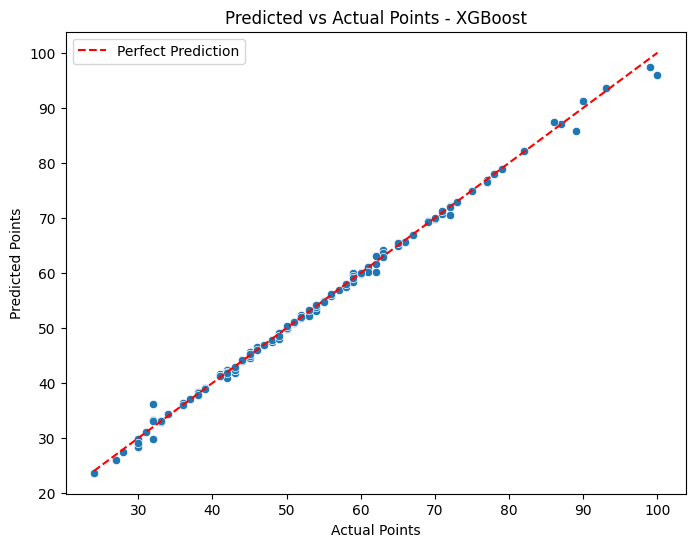

In [20]:
#Predicted vs Actual
y_pred = best_model.predict(X_test)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title(f'Predicted vs Actual Points - {best_model_name}')
plt.legend()
plt.show()

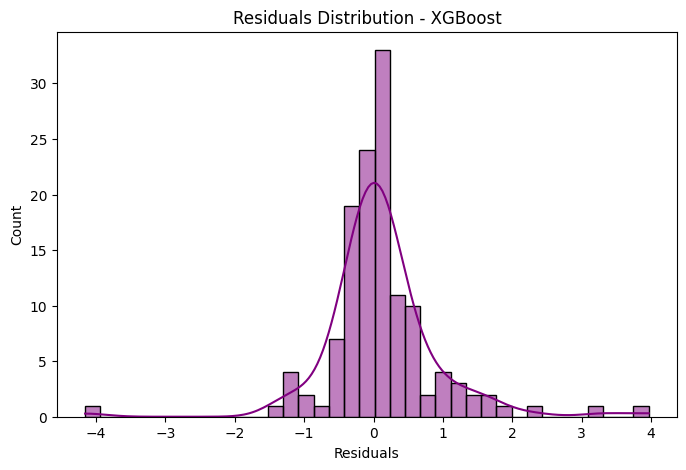

In [21]:
#Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title(f'Residuals Distribution - {best_model_name}')
plt.show()

/tmp/ipython-input-1279137373.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values[:10], y=fi.index[:10], palette='viridis')


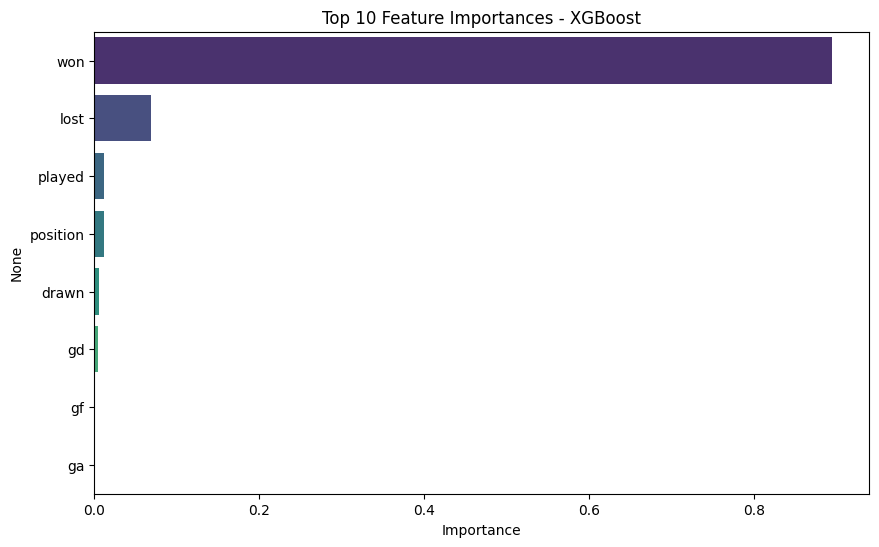

In [22]:
#Feature Importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = best_model.coef_
else:
    importances = None

if importances is not None:
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=fi.values[:10], y=fi.index[:10], palette='viridis')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()

In [23]:
#Print Final Report
print(f"\nBest Model: {best_model_name}")
print(f"MAE: {results[best_model_name]['mae']:.2f}")
print(f"RMSE: {results[best_model_name]['rmse']:.2f}")
print(f"R²: {results[best_model_name]['r2']:.3f}")



Best Model: XGBoost
MAE: 0.49
RMSE: 0.84
R²: 0.997
